# Совместные векторные представления
Идея представления данных в виде обучаемых векторных представлений очень плодотворна. Векторные представления не обладают физической размерностью, значит появляется возможность совместной обработки данных разной природы, например, текста и изображений, текста и звуков и др.

Одна из задач, которую можно решать таким образом, это аннотация изображений - автоматическое текстовое описание *содержания* изображения. Вариант решения показан ниже.  

# Аннотация изображений.


Вспомним, как работают генераторы текста.

Начиная с некоторого начального токена (начала предложения), нейронная сеть-генератор предсказывает следующий токен (слово), используя его предсказывается следующий и так далее, пока не будет предсказан токен конца предложения или не достигнем максимальной длины предложения.



Но что, если мы будем начинать генерацию не с токена начала предложения, а с другого токена? Так мы сможем продолжить предложение, т.е. сгенерировать такие последующие токены, которые связаны с начальным.

Каждый токен представляется в виде некоторого вектора, например word2vec вектора или похожего. Но ведь нас совершенно не интересует источник таких векторов, как они получились, лишь бы они были не банальны, описывали связи между токенами.



**Давайте в качестве начального вектора возьмем не вектор слова, а, например, вектор какого-либо изображения**!
А вы помните, что изображения тоже можно представлять векторами.

Тогда можем создать такие "предложения":

* изображение, представленное вектором
* текст - описание этого изображения, представленное последовательностью векторов.

То есть, изображение это некоторое "слово" в векторном представлении и мы добавили его в начало предложения.

Имея соответствующие данные об изображении и их описании (аннотации) можем обучить генератор создавать описания для изображений. Такие наборы данных, конечно, существуют.



В более сложных случаях, когда наша нейронная сеть-генератор является рекуррентной и имеет несколько слоев, то мы должны задавать начальные состояния этих слоев. Пусть эти начальные состояния и будут задаваться вектором изображения.  

Такую задачу, когда мы можем для изображений автоматически создавать их текстовые описания, назвали **аннотированием изображений**.

С технической точки зрения это тот же процесс генерации текста, только начинающийся для начального состояния сети, определяемого вектором изображения.

Сегодня мы решим такую задачу, будем использовать генератор на основе вентильной GRU сети.



## Схема генерации

Для создания вектора изображения используем предобученную сеть VGG16, которая обучалась классификации изображений. Но будем снимать результаты не с выхода этой сети, а с предпоследнего полносвязного слоя, который и даст нам вектор для изображения. В этой модели размер такого вектора составляет 4096.  

Вектор изображения будет использоваться как начальное состояние для рекуррентной GRU сети (см. рис.). В нашем примере такая сеть имеет 512 нейронов на слоях, значит и вектора состояний, в том числе вектор начального состояния, должны быть размером 512.

Каждый из рекуррентных слоев (их три в нашем примере) будет использовать тот же вектор изображения как начальное состояние. Напомним, что в GRU состояние и выход не различаются (в отличие от LSTM), так что нам не надо задумываться о таком отличии.  

Чтобы перевести вектор размером 4096 в вектор размером 512 используем полносвязный слой из 512 нейронов с 4096 входами.

Все описания изображений, которые есть в наших данных дополним токенами начала предложения (обозначим "ssss") и конца предложения (обозначим "eeee").

Входная последовательность для картинки медведя с описанием "big brown bear sitting", будет выглядеть так:
* начальное состояние сети перед генерацией: вектор ИЗОБРАЖЕНИЯ медведя.
* первый токен: ssss
* второй токен: слово "big"
* третий токен: слово "brown"
* четвертый токен: слово "bear"
* пятый токен: слово "sitting"
* шестой токен: eeee

Цель генерации - предсказывать следующий токен, поэтому указания учителя это следующий токен в предложении.
* ssss -> "big"
* "big" -> "brown"
* "brown" -> "bear"
* "bear" -> "sitting"
* "sitting" -> eeee
* eeee -> пусто (токен 0)


![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/22_image_captioning_flowchart.png?raw=1)

Изначально данные представлены в виде изображений и их описаний в текстовом виде.

Нужно будет создать словарь токенов, токенизировать (слой tokenizer) эти описания, и перевести токены (это целые числа - номера слов в словаре) в векторные представления (слой embedding).

Последний слой генератора - полносвязный, с числом нейронов равным числу токенов в словаре.

Для реализации будем использовать Keras TensorFlow.

Изображения участвуют в генерации только один раз, вектора изображений неизменны и не переобучаются. Поэтому мы однократно пропустим все изображения через VGG сеть, получим их вектора и сохраним их. Дальше будем пользоваться уже сохраненными векторами.

Объем векторов довольно большой, не поместится в память компьютера Colab, поэтому сохранять будем в кэш на диске.

Нам понадобятся вспомогательные файлы из репозитория [Hvass-Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials) (кстати, советую посмотреть и другие примеры оттуда).

Если же у вас и на диске не хватает места - пропустите этот шаг в коде и загрузите уже сохраненный кеш, но изучите, как данные загружаются.


In [1]:
# Утилиты
# для работы с кэшем
!wget https://raw.githubusercontent.com/neuralcomputer/ML_School/main/cache.py
# для работы с данными COCO
!wget https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/coco.py
# для загрузки данных
!wget https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/download.py

--2025-04-23 18:48:02--  https://raw.githubusercontent.com/neuralcomputer/ML_School/main/cache.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4991 (4.9K) [text/plain]
Saving to: ‘cache.py’

cache.py            100%[===================>]   4.87K  --.-KB/s    in 0s      

2025-04-23 18:48:02 (67.9 MB/s) - ‘cache.py’ saved [4991/4991]

--2025-04-23 18:48:02--  https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/coco.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6671 (6.5K) [text/plain]
Saving to: ‘coco.p

In [2]:
# подключим все библиотеки
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image # картинки
from cache import cache # кэш, работа с диском

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding # слои
from tensorflow.keras.applications import VGG16 # предобученная сеть
from tensorflow.keras.optimizers import RMSprop # метод обучения
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer # создание токенов
from tensorflow.keras.preprocessing.sequence import pad_sequences # предобработка предложений

Проверим версии:

In [4]:
tf.__version__

'2.18.0'

In [5]:
tf.keras.__version__

'3.8.0'

# Загрузка данных

Большие наборы изображений и описаний к ним уже существуют, мы используем набор данных COCO. http://cocodataset.org

Здесь для одного изображения даны несколько разных описаний.

In [6]:
# утилита для работы с данными COCO
import coco

Загружаем данные, если еще небыли загружены.

**WARNING! Объем ОЧЕНЬ большой! Обучающие данные занимают 19 GB, проверочные 816 MB!**

Придется подождать. Или пропустите этот шаг.

In [7]:
# загружаем данные  / пропустите шаг и перейдите к альтернативной загрузке
coco.maybe_download_and_extract() # Ждите....

- Download progress: 100.0%
Download finished. Extracting files.
Done.
- Download progress: 100.0%
Download finished. Extracting files.
Done.
- Download progress: 100.0%
Download finished. Extracting files.
Done.


### *Альтернативная загрузка*

Если все плохо, места на диске не хватает, времени ждать загрузки обучающих данных нет, то загрузим ранее полученные файлы описаний и векторов изображений и небольшой объем проверочных изображений.

In [ ]:
''' ЭТА КОДОВАЯ ЯЧЕЙКА ТОЛЬКО ДЛЯ СЛУЧАЯ АЛЬТЕРНАТИВНОЙ ЗАГРУЗКИ '''

import gdown # модуль для загрузки с гугл-диска
import os
curdir=os.getcwd()
os.makedirs(coco.data_dir,exist_ok=True)
os.chdir(coco.data_dir)

# файлы с описанием обучающие
url = 'https://drive.google.com/uc?id=1cVZRM2lNwtQrr5E8peLjLmyRF-Oe0Uhp&export=download&confirm=t' # адрес
output ='records_train.pkl' # название для загружаемого файла
gdown.download(url, output, quiet=False)

# файлы с описанием проверочные
url = 'https://drive.google.com/uc?id=1sCnaJQwtikJ7Pp_tDPCBiQF6D4h1seHe&export=download&confirm=t' # адрес
output ='records_val.pkl' # название для загружаемого файла
gdown.download(url, output, quiet=False)

# файлы с векторами изображений обучающие
url = 'https://drive.google.com/uc?id=1z-IIMhEccKO6IbEOeWa2QUP37NamYEVb&export=download&confirm=t' # адрес
output = 'transfer_values_train.pkl' # название для загружаемого файла
gdown.download(url, output, quiet=False)

# файлы с векторами изображений проверочные
url = 'https://drive.google.com/uc?id=1H0XgMkpm1H3Qy5zYAJFByUwoOVc8IY6j&export=download&confirm=t' # адрес
output ='transfer_values_val.pkl' # название для загружаемого файла
gdown.download(url, output, quiet=False)

os.chdir(curdir)



Downloading...
From: https://drive.google.com/uc?id=1cVZRM2lNwtQrr5E8peLjLmyRF-Oe0Uhp&export=download&confirm=t
To: /content/data/coco/records_train.pkl
100%|██████████| 41.6M/41.6M [00:00<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sCnaJQwtikJ7Pp_tDPCBiQF6D4h1seHe&export=download&confirm=t
To: /content/data/coco/records_val.pkl
100%|██████████| 1.75M/1.75M [00:00<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z-IIMhEccKO6IbEOeWa2QUP37NamYEVb&export=download&confirm=t
To: /content/data/coco/transfer_values_train.pkl
100%|██████████| 969M/969M [00:10<00:00, 96.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H0XgMkpm1H3Qy5zYAJFByUwoOVc8IY6j&export=download&confirm=t
To: /content/data/coco/transfer_values_val.pkl
100%|██████████| 41.0M/41.0M [00:00<00:00, 138MB/s]


In [ ]:
''' ЭТА КОДОВАЯ ЯЧЕЙКА ТОЛЬКО ДЛЯ СЛУЧАЯ АЛЬТЕРНАТИВНОЙ ЗАГРУЗКИ '''
import download
# Загрузим проверочные изображения и описания ~ 5 минут
data_dir=coco.data_dir
data_url=coco.data_url
filenames = ["zips/val2017.zip",
                 "annotations/annotations_trainval2017.zip"]
#
for filename in filenames:
    #
    url = data_url + filename
    print("Downloading " + url)
    download.maybe_download_and_extract(url=url, download_dir=data_dir)


- Download progress: 100.0%
Download finished. Extracting files.
Done.
- Download progress: 100.0%
Download finished. Extracting files.
Done.


Посмотрим, что мы загрузили. Получим названия файлов изображений и описания для обучающих данных.

In [8]:
# обучающие
_, filenames_train, captions_train = coco.load_records(train=True)

- Data will be loaded from outside to:data/coco/records_train.pkl
- Data saved to cache-file: data/coco/records_train.pkl


Количество обучающих примеров:

In [9]:
num_images_train = len(filenames_train)

num_images_train

118287

Названия файлов изображений и описания для проверочных данных:

In [10]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data will be loaded from outside to:data/coco/records_val.pkl
- Data saved to cache-file: data/coco/records_val.pkl


In [12]:
num_images_val = len(filenames_val)

num_images_val

5000

### Вспомогательные функции для загрузки и показа изображений


In [13]:
# загрузка изображений
def load_image(path, size=None):
    """
    Загружаем изображение и масштабируем его к нужному размеру.
    """

    # загрузка через PIL.
    img = Image.open(path)

    # масштабирование.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # конвертируем в numpy array.
    img = np.array(img)

    # приводим пиксели в диапазон 0.0 ... 1.0
    img = img / 255.0

    # Если двумерные серые, то конвертируем в трехмерные RGB массивы.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

Функция показа изображения и подписи к нему.

In [14]:
# Функция показа изображения и подписи к нему.
def show_image(idx, train):
    """
    Отображаем изображение по его индексу в обучающем или проверочном наборе
    """

    if train:
        # изображения из обучающего набора.
        dir = coco.train_dir # директория
        filename = filenames_train[idx] # название файла изображения
        captions = captions_train[idx] # описание его
    else:
        # изображения из проверочного набора.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Путь к файлу изоражения.
    path = os.path.join(dir, filename)

    # Печатаем (все) описания.
    for caption in captions:
        print(caption)

    # загружаем и отображаем изображение.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Пример изображения и описания


A woman posing for the camera standing on skis.
a woman standing on skiis while posing for the camera
A woman in a red jacket skiing down a slope
A young woman is skiing down the mountain slope. 
a person on skis makes her way through the snow


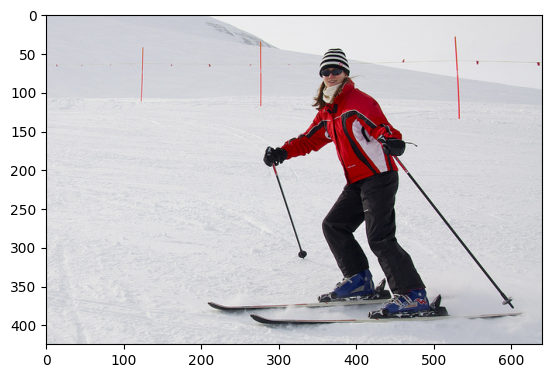

In [15]:
# должны быть загружены обучающие или проверочные изображения
show_image(idx=5, train=False)

#Получение векторов изображений предобученной сетью VGG16

Сеть VGG16 была обучена на наборе ImageNet классификации изображений. Сеть состоит из сверточных слоев и завершается полносвязными слоями.  Размер всей модели (атрибут `include_top=True`) 528 MB. Если не загружать полносвязные слои (`include_top=False`), то 57 MB, но нам потребуется предпоследний полносвязный слой.

In [16]:
# создаем и загружаем предобученную сеть
image_model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Архитектура сети:

In [17]:
image_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Мы используем выход предпоследнего полносвязного слоя `fc2` для векторов изображений.

In [18]:
# слой, с которого будем снимать выходы
transfer_layer = image_model.get_layer('fc2')

Создадим новую нейронную сеть, у которой вход такой же как у VGG16, а выход берется со слоя `fc2`.

In [19]:
# Нейронная сеть - векторизатор изображений
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

Размер входа:

In [20]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

Для каждого изображения вернется вектор размера:

In [21]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Векторизация изображений

Нам не нужно обучать сеть-векторизатор изображений, она уже обучена. Эти вектора все время одни и те же. Поэтому сохраним вектора для всех изображений в новый набор данных. Это не быстрый процесс, ждите. Если ранее вы уже загрузили кэш-файлы, данные будут взяты из них.

In [22]:
# функция для отображения прогресса векторизации
def print_progress(count, max_count):
    # процент завершения.
    pct_complete = count / max_count

    # Статусное сообщение (\r значит, что строка будет переписывать себя)
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # печатаем
    sys.stdout.write(msg)
    sys.stdout.flush()

Функция для векторизации изображений.

In [23]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Берет файлы изображений filenames в директории data_dir
    используя предобученную сеть создает вектора изображений.

    Выполняется пакетами batch_size для более эффективной работы GPU.
    """

    # число изображений.
    num_images = len(filenames)

    # массив для пакета изображений. float16 для экономии памяти
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # массив для векторов изображений. float16 для экономии памяти
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # индекс изображения.
    start_index = 0

    # пакетная обработка изображений.
    while start_index < num_images:
        # печатаем прогресс.
        print_progress(count=start_index, max_count=num_images)

        # индекс последнего изображения в текущем пакете.
        end_index = start_index + batch_size

        # убедимся что не превышает количество изображений.
        if end_index > num_images:
            end_index = num_images

        # последний пакет может иметь другую длину, посчитаем длину пакета.
        current_batch_size = end_index - start_index

        # загружаем все изображения из пакета.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # путь к изображению.
            path = os.path.join(data_dir, filename)

            # загружаем и масштабируем, возвращается numpy-array.
            img = load_image(path, size=img_size)

            # записывам в массив.
            image_batch[i] = img

        # Расчитываем вектора для изображений, пропуская их через предобученную сеть-векторизатор.
        # у последнего пакета может быть другой размер.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # сохраняем вектора в массив.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # увеличиваем индекс для следующей итерации.
        start_index = end_index

    #
    print()

    return transfer_values

Функция для сохранения в кэш обучающих данных.

In [24]:
# Функция для обработки изображений и сохранения в кэш
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # путь к файлу кэша.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # если кэш уже есть - данные будут загружены из него,
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Аналогичная функция для обработки проверочных данных.

In [25]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # файл кэша.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # кэшируем
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

На случай, если вы не загружали сами изображения можно скачать кэш-файлы уже посчитанных векторов изображений для обучающих и проверочных примеров. Если файлы уже есть на диске в директории coco.data_dir, то функция `cache`  просто загрузит их, иначе будет рассчитывать их сама.

Обработка большого количества изображений сложной сетью VGG это долгий процесс (30 минут на GTX 1070 GPU), наберитесь терпения.

In [26]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data will be loaded from outside to:data/coco/transfer_values_train.pkl
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Обработка проверочного набора займет примерно 90 секунд.

In [27]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data will be loaded from outside to:data/coco/transfer_values_val.pkl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# Токенизация

Нейронные сети не работают напрямую со словами, вместо этого делаются токены - целочисленные представления слов, показывающие номер этого слова в словаре. Затем эти токены переводятся в векторные представления.

Также нам надо предобработать последовательности, добавить токены начала и конца предложения.

In [28]:
mark_start = 'ssss ' # токен начала
mark_end = ' eeee' #  токен конца предложения

Функция для добавления токенов начала и конца. Описания изображений представлены в виде списка списков, так что потребуются вложенные циклы для их обработки.

In [29]:
# добавление токенов начала и конца предложения
# добавляем маркеры к каждому описанию из списка описания для текущего изображения, для описаний всех изображений
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]

    return captions_marked

Обрабатываем описания.

In [30]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

А так описания выглядели без маркеров начала и конца.

In [31]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

Список списков временно переведем в плоское представление,

In [32]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]

    return captions_list

In [33]:
captions_train_flat = flatten(captions_train_marked)

Зададим максимальное количество слов в словаре, например  10000 наиболее встречаемых в обучающих данных.

In [34]:
num_words = 10000

И создадим токенизатор используя класс Keras Tokenizer. Этот токенизатор и сделает словарь и токены для описаний с помощью встроенного в класс метода `text_to_sequences()`. Но он работает с плоским списком, а не списком списков, для этого и преобразовывали и придется сделать свой класс токенизатора, наследующий от Tokenizer, в который добавить все необходимые нам функции.

In [35]:
class TokenizerWrap(Tokenizer):
    """Токенизатор Tokenizer-class"""

    def __init__(self, texts, num_words=None):
        """
        Инициализация
        :param texts: Список строк набора данных.
        :param num_words: Максимально число слов в словаре.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # создание словаря.
        self.fit_on_texts(texts)

        #отображение: по индексу получить слово.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
    # по одному токену (целое число) получить его слово
    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word
    # по набору токенов получить предложение - строку из слов разделенных пробелами
    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # список отдельных слов.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]

        # объединяем слова через пробел.
        text = " ".join(words)

        return text
    # из описания (список списков) получить токены (целые)
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """

        # функция text_to_sequences() (встроена в классе) принимает список текстов, а нам нужен список списков.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]

        return tokens

Создаем токенизатор для обучающих данных. Обратите внимание мы используем плоский список, а не список списков.

In [36]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 6.48 s, sys: 18.2 ms, total: 6.5 s
Wall time: 6.49 s


Узнаем, какой токен назначен началу предложения "ssss", он нам потом пригодится.

In [37]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

И для конца предложения "eeee":

In [38]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Теперь переводим все описания в последовательности токенов (список списков).

In [39]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 7.01 s, sys: 18.5 ms, total: 7.03 s
Wall time: 7.07 s


Пример последовательности токенов:

In [40]:
tokens_train[0] # начинается с 2 (токен начала) заканчивается 3 (токен конца)

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

Ей соответствует описание:

In [41]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

# Генератор пакетов данных

Каждому изображению соответствует 5 разных описаний. Нейронная сеть должна обучаться на данных изображение + одно описание. Нужно разделить все описания изображений. По умолчанию такого не сделать, нам надо создать свой генератор пакетов обучающих данных.

Такой генератор должен брать случайно изображение и выбирать случайно же одно из его описаний.

Собирать несколько таких последовательностей в пакет.

Генератор оформлен в виде функции `batch_generator` и возвращает один пакет - тензор определенной размерности.

Вспомогательная функция `get_random_caption_tokens` возвращает список случайно выбранной последовательности токенов для конкретного обучающего изображения, заданного индексом.

In [43]:
def get_random_caption_tokens(idx):
    """
    Получает список индексов изображений в обучающем наборе,
    выбирает случайно одно из описаний для каждого изображения и возвращает список всех таких токенов описания.
    """
    # инициализируем пустой список результата.
    result = []

    # для каждого индекса изображения.
    for i in idx:
        # индекс i это индекс изображения в обучающем наборе
        # каждое изображение сожержит 5 описаний
        # которые сконвертированы в последовательности токенов в tokens_train.
        # выбирается одно из описаний случайно.

        # случайный индекс описания.
        j = np.random.choice(len(tokens_train[i]))

        # берем токены jого описания изображения i.
        tokens = tokens_train[i][j]

        # добавляем к списку
        result.append(tokens)

    return result

Генератор пакетов создает пакет данных заданного размера batch_size. Поскольку изображения и их описания выбираются случайно (с повторением), то возможно что некоторые данные не будут выбраны никогда или будут выбраны несколько раз. Но это не страшно если пакетов будет много.  

In [44]:
def batch_generator(batch_size):
    """
    Генератор пакетов данных.

    """

    # бесконечный цикл.
    while True:
        # Список случайных индексов обучающих изображений.
        idx = np.random.randint(num_images_train,
                                size=batch_size)

        # вектора таких изображений, ранее полученные из предобученной сети
        transfer_values = transfer_values_train[idx]

        # выбираем случайно токены одного из описаний для каждого из изображений
        tokens = get_random_caption_tokens(idx)

        # число токенов в каждом выбранном описании.
        num_tokens = [len(t) for t in tokens]

        # максимум из них.
        max_tokens = np.max(num_tokens)

        # Добиваем до максимального размера нулями токены всех более коротких описаний,
        # тогда размеры их будут одинаковы. Нули (пустые токены) добавляются в конец.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')

        # Пакет состоит из пар входы - указания учителя.
        # Указания учителя это те же самые последовательности, но смещенные на один так времени (на один токен)
        decoder_input_data = tokens_padded[:, 0:-1] # входы: токены от 0 до предпоследнего
        decoder_output_data = tokens_padded[:, 1:] # указания учителя: от 1 до последнего

        # Пакет содержит во входах также и вектора изображений, оформим как словарь
        x_data = \
        {
            'decoder_input': decoder_input_data, # входы: токены описаний
            'transfer_values_input': transfer_values # входы: вектора изображений
        }

        # Желаемые выходы, тоже как словарь.
        y_data = \
        {
            'decoder_output': decoder_output_data # Указания учителя: токены описаний
        }

        yield (x_data, y_data) # генератор возвращает два словаря

Для лучшей работы памяти RAM и GPU данные обрабатываются пакетами. Можно уменьшить размер пакета для экономии памяти.

In [45]:
batch_size = 384

Создаем объект генератора. Обратите внимание, что это генератор, для которого будет выполняться очередная итерация цикла раз за разом при вызове методом next(), но так как у нас прописан бесконечный цикл, то вызывать можем любое число раз. Подробней про "генераторы" можно почитать [здесь](https://habr.com/ru/articles/132554/) или в документации Python.  

In [46]:
generator = batch_generator(batch_size=batch_size)

Методом `next()` можно получить следующий пакет из генератора.

In [47]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Пример векторов изображений из пакета - это вектор размерностью 4096.

In [48]:
batch_x['transfer_values_input'][0]

array([0.2094, 0.    , 1.432 , ..., 0.    , 0.    , 1.089 ], dtype=float16)

In [49]:
batch_x['transfer_values_input'][0].shape

(4096,)

Пример последовательности входных токенов (описания) для этого изображения - массив размера 22  (для этого примера), столько токенов максимально было в описании. Начинается с токена 2 (начало), заканчивается токеном 3 (конец), добит токенами 0 (пусто) до нужного размера.

In [50]:
batch_x['decoder_input'][0]

array([   2,    1,  445, 1275,  104,  185,  102,   20,   12,  104,   43,
          5,  112,    3,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [51]:
batch_x['decoder_input'][0].shape

(48,)

Пример последовательности выходных токенов (указания учителя) для этого изображения - массив размера 22  (для этого примера), столько токенов максимально было в описании. Отличается от входного смещением на один элемент.

In [52]:
batch_y['decoder_output'][0]

array([   1,  445, 1275,  104,  185,  102,   20,   12,  104,   43,    5,
        112,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [53]:
batch_y['decoder_output'][0].shape

(48,)

### Количество шагов на эпоху

Эпоха - это полный однократный расчет всех обучающих данных. Вообще, в нашем примере понятие эпохи бессмысленно, так как данные выбираются случайно и это может продолжаться бесконечно долго. Но для совместимости с Keras, где мы указываем количество эпох обучения, давайте прикинем, сколько пакетов нам понадобится на одну "эпоху".

Количество описаний для каждого изображения в обучающих данных:

In [54]:
num_captions_train = [len(captions) for captions in captions_train]

Общее число описаний в обучающих данных:

In [55]:
total_num_captions_train = np.sum(num_captions_train)

Если бы все эти описания выбирались постепенно, а не случайно, то на одну эпоху при размере пакета batch_size пришлось бы вот столько пакетов:

In [56]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1541

Пусть это число и обозначает количество пакетов на одну эпоху.

# Создание рекуррентной сети

Архитектуру сети вы видели на рисунке. Она состоит из:
- слоя токенизатора (Tokenizer), переводящего слова описания в целочисленные токены, заранее обученного с уже посчитанными выходами.
- слоя векторного представления токенов (Embedding), который переводит целочисленные токены в вектора заданной размерности embedding_size=128, это обучаемый слой.
- трех рекуррентных обучаемых слоев GRU с заданным количеством нейронов (у нас state_size=512 в каждом).
- полносвязного обучаемого слоя (Dense) с числом нейронов равным числу токенов в словаре и который возвращает уровни уверенности в токенах. Потом эти уровни будут переведены в целочисленные токены результата, которые затем отображаются в слова описания.
- и, не забудем, отдельного полносвязного слоя (DenseMap), который принимает вектор изображения, переводит его в размер state_size=512 (число нейронов GRU) и предоставляет такой выход как **начальное состояние** для всех трех GRU слоев. Это также обучаемый слой.  

Используем функциональный способ Keras для создания нейронной сети, когда сначала создаем слои, а потом указываем способ их связи в функции.

In [57]:
state_size = 512

In [58]:
embedding_size = 128

### Создание слоев нейронной сети
Создадим входы с векторами изображений:

In [59]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

Создадим полносвязный слой для перевода векторов изображений в размер 512. Экспериментально было найдено, что лучше всего использовать функцию активации `tanh` с диапазоном выходов от -1 до 1.

In [60]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

Слой токенизатора уже был создан заранее и обучен, слова переведены в токены, еще раз делать его не нужно.

Создадим входы с последовательностями токенов описания. Здесь `None` означает, что длина последовательности может быть любой.

In [61]:
decoder_input = Input(shape=(None, ), name='decoder_input')

Создадим слой векторного представления токенов:

In [62]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

Создадим 3 GRU слоя, указываем размер состояния (оно же количество нейронов в слое) и что возвращаться должна последовательность.

In [63]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

GRU слои возвращают массивы размером `[batch_size, sequence_length, state_size]`, где каждое слово закодировано вектором длины `state_size`.

Такие вектора переводятся в полносвязном слое с функцией активации softmax в вектор размерности по числу слов в словаре (num_words=10000).

In [64]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Соединение слоев

Теперь укажем как именно слои соединяются в функции `connect_decoder`.

In [65]:
def connect_decoder(transfer_values):
    # Принимает заранее созданные вектора изображений как
    # начальные состояния:
    initial_state = decoder_transfer_map(transfer_values)

    # net - выход нейронной сети.

    # сначала вход - токены описаний
    net = decoder_input

    # этот вход поступает на векторизатор.
    net = decoder_embedding(net)

    # выход векторизатора поступает на первый GRU слой с начальным состоянием из вектора изображения.
    net = decoder_gru1(net, initial_state=initial_state)
    # выход первого GRU слоя поступает на второй GRU слой с таким же начальным состоянием
    net = decoder_gru2(net, initial_state=initial_state)
    # выход второго GRU слоя поступает на третий GRU слой с таким же начальным состоянием
    net = decoder_gru3(net, initial_state=initial_state)

    # наконец, выход третьего GRU слоя поступает на полносвязный слой.
    decoder_output = decoder_dense(net)

    return decoder_output # он и возвращается

Имеем функциональное описание нейронной сети, где указана по сути функция расчета выходов ее. Осталось только указать, что является входами и выходами из сети и она готова. Keras теперь знает как посчитать выход из входа и здесь все использованные массивы (тензоры) и функции поддерживают автодифференцирование.

In [66]:
# это выход модели
decoder_output = connect_decoder(transfer_values=transfer_values_input)
# создаем модель нейронной сети
decoder_model = Model(inputs=[transfer_values_input, decoder_input], # входы в нее
                      outputs=[decoder_output]) # выходы из нее

### Компилирование модели

Указания учителя, по идее, это унитарные (one-hot) вектора размером по числу слов в словаре. Создавать такие массивы напрямую было бы не эффективно.   

В Keras есть функция ошибки `sparse cross-entropy` которая принимает целочисленные входы вместо унитарных векторов. Это гораздо эффективнее, чем просто `cross-entropy`.

Используем метод RMSprop для обучения, в экспериментах он показал лучшие результаты.

In [68]:
decoder_model.compile(optimizer=RMSprop(learning_rate=1e-3),
                      loss='sparse_categorical_crossentropy')

Для сохранения промежуточных этапов обучения будем использовать прерывание:

In [69]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=22_checkpoint.keras

In [70]:
path_checkpoint = '22_checkpoint.weights.h5'  # Изменили расширение на .weights.h5
callback_checkpoint = ModelCheckpoint(
    filepath=path_checkpoint,
    save_weights_only=True,  # Сохраняем только веса
    verbose=1
)

Для отображения процесса обучения в TensorBoard будем использовать прерывание:

In [71]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [72]:
callbacks = [callback_checkpoint, callback_tensorboard]

# Обучение модели

Одна эпоха обучения занимает около 7 минут на GTX 1070 GPU. Для хоть немного правдоподобной генерации потребуется не меньше 20 эпох. Вообще обучение долгий процесс. Чтобы в этом примере получить более-менее правдоподобные описания картинок, придется обучать сеть не менее 10 часов. Сохранения очень помогут в этом.

Кстати, если бы мы не рассчитали вектора изображений заранее, а делали бы это каждый раз при обучении, то одна эпоха заняла бы 40 минут, так как нужно было бы каждый раз рассчитывать большую сеть VGG16.

Готовы начать обучение сети?

In [ ]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=2, # число эпох, задайте побольше
                  callbacks=callbacks)

Epoch 1/2
1541/1541 [==============================] - ETA: 0s - loss: 1.8718
Epoch 1: saving model to 22_checkpoint.keras
1541/1541 [==============================] - 311s 196ms/step - loss: 1.8718
Epoch 2/2
1541/1541 [==============================] - ETA: 0s - loss: 1.5021
Epoch 2: saving model to 22_checkpoint.keras
1541/1541 [==============================] - 301s 195ms/step - loss: 1.5021
CPU times: user 8min 1s, sys: 12.2 s, total: 8min 13s
Wall time: 10min 28s


### Загрузка точки сохранения

Если вы уже обучили нейронную сеть и имеете сохраненную точку восстановления процесса обучения, то ее можно загрузить и начать генерацию описаний или продолжить обучение.

In [ ]:
# Загрузить точку восстановления
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
# Сохранить логи
!zip -r logs.zip 22_logs
from google.colab import files
files.download('logs.zip')

# Генерация описаний

После обучения мы можем создавать описания картинок:
* из картинки получаем ее вектор,
* подаем его в качестве начального состояния на рекуррентные слои
* создаем токен начала описания
* обученной сетью предсказываем следующий токен.
* используя токен начала и только что предсказанный, предсказываем второй токен в описании и т.д.
* делаем так, пока не предскажется токен конца предложения или не достигнем максимальной длины предложения.

Еще раз - для генерации мы **многократно** используем обученную сеть предсказывая все новые и новые токены.

Генерация описаний реализована в виде функции:

In [73]:
def generate_caption(image_path, max_tokens=30):
    """
    Принимает путь к файлу изображения и максимальное число токенов в описании.
    Возвращает описание, может быть короче чем максимальная длина
    """

    # загружаем и масштабируем изображение.
    image = load_image(image_path, size=img_size)

    # 3-мерный массив в 4-мерный, т.к. первое измерение - пакеты.
    image_batch = np.expand_dims(image, axis=0)

    # Пропускаем изображение через предобученную сеть, получаем его вектор
    transfer_values = image_model_transfer.predict(image_batch)

    # резервируем 2-мерный массив для токенов входа,
    # и хоть это одномерный вектор, но, опять же, первое измерение - пакеты,
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=int)# проинициализируем нулями

    # первый токен это токен начала 'ssss '.
    token_int = token_start

    # инициализируем пустое текстовое описание.
    output_text = ''

    # инициализируем число предсказанных токенов.
    count_tokens = 0

    # В цикле пока не встретится токен конца ' eeee'
    # или не будет достигнуто максимальное количество токенов.
    while token_int != token_end and count_tokens < max_tokens:
        # обновляем входную последовательность
        # добавив текущий предсказанный токен в нее.
        # В самом начале генерации это токен начала предложения
        decoder_input_data[0, count_tokens] = token_int

        # Представляем входы в виде словаря, как и было сделано при обучении
        x_data = \
        {
            'transfer_values_input': transfer_values, # вектор изображения
            'decoder_input': decoder_input_data #  текущая последовательность входных токенов
        }

        # подаем входы в модель и предсказываем следующий токен.
        decoder_output = decoder_model.predict(x_data)

        # Раз предсказание идет на один такт вперед,
        # то предсказание для следующего токена возвращается
        # в том же индексе, что и текущий входной токен
        token_onehot = decoder_output[0, count_tokens, :]

        # предсказание это многомерный вектор уровней уверенности в токенах
        # размер вектора по числу слов в словаре
        # выберем токен с максимальной уверенностью
        token_int = np.argmax(token_onehot) # это целое число - индекс

        # по индексу токена находим в словаре слово.
        sampled_word = tokenizer.token_to_word(token_int)

        # и добавляем его к результирующему описанию.
        output_text += " " + sampled_word

        # увеличиваем счеткик токенов.
        count_tokens += 1

    # окончательные токены описания (здесь не используются)
    output_tokens = decoder_input_data[0]

    # рисуем картинку.
    plt.imshow(image)
    plt.show()

    # печатаем описание к ней.
    print("Predicted caption:")
    print(output_text)
    print()

### Примеры генерации

Загрузим картинку.

In [74]:
!wget https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/images/parrot_cropped1.jpg

--2025-04-23 20:54:32--  https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/images/parrot_cropped1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37085 (36K) [image/jpeg]
Saving to: ‘parrot_cropped1.jpg’

parrot_cropped1.jpg 100%[===================>]  36.22K  --.-KB/s    in 0.007s  

2025-04-23 20:54:33 (5.26 MB/s) - ‘parrot_cropped1.jpg’ saved [37085/37085]



1/1 [==============================] - 0s 22ms/step


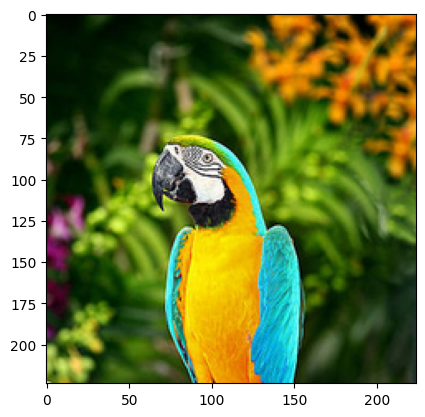

Predicted caption:
 a bird is sitting on a branch branch eeee



In [ ]:
# Сгенерируем описание для нее
generate_caption("parrot_cropped1.jpg")

Для картинок из обучающего или проверочного наборов COCO сделаем функцию для генерации описания.

In [75]:
def generate_caption_coco(idx, train=False):
    """
    Принимает индекс изображения в обучающем train=True или проверочном train=False наборе
    Рисует картинку и делает ее описание
    """

    if train:
        # картинки из обучающего набора.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # или из проверочного
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # путь к картинке.
    path = os.path.join(data_dir, filename)

    # создаем описание.
    generate_caption(image_path=path)

    # печатаем также настоящие описания для этой картинки из набора данных.
    print("True captions:")
    for caption in captions:
        print(caption)

Проверьте работу и сравните сгенерированные описания со сделанными людьми.

1/1 [==============================] - 0s 21ms/step


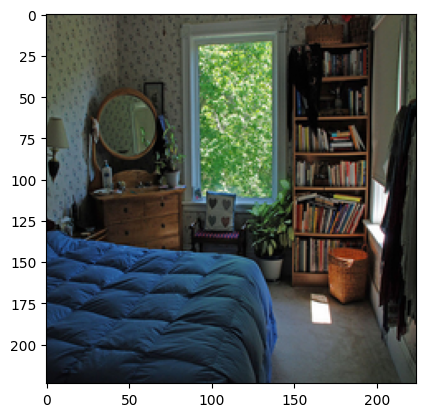

Predicted caption:
 a bed with a bed and a bed eeee

True captions:
Bedroom scene with a bookcase, blue comforter and window.
A bedroom with a bookshelf full of books.
This room has a bed with blue sheets and a large bookcase
A bed and a mirror in a small room.
a bed room with a neatly made bed a window and a book shelf


In [ ]:
generate_caption_coco(idx=2, train=False)

1/1 [==============================] - 0s 20ms/step


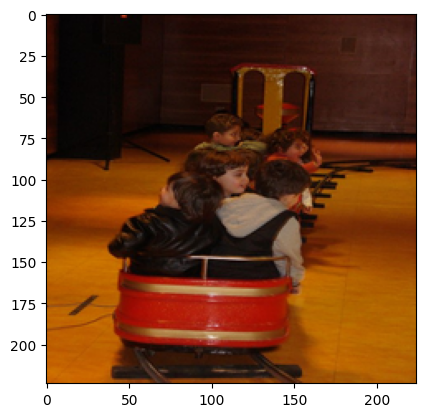

Predicted caption:
 a table with a bunch of cake on it eeee

True captions:
some children are riding on a mini orange train
Several children are riding on a toy train ride.
The children are riding on an indoor train. 
Several children on a small  indoor kiddie train.
A group of children ride on an indoor train.


In [ ]:
generate_caption_coco(idx=12, train=False)

1/1 [==============================] - 0s 20ms/step


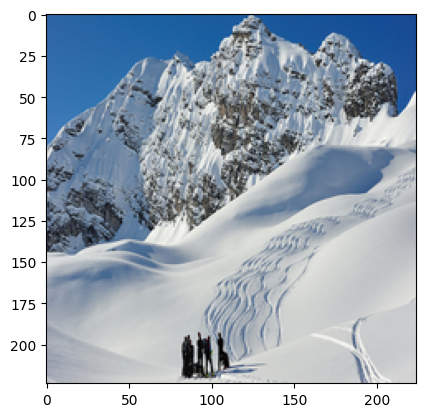

Predicted caption:
 a person is riding a wave on a surfboard eeee

True captions:
a group of people riding skis on a snowy surface
A group of skiers have left a trail through the snow on the mountain. 
The paths of some snowboarders carved in a mountain slope.
Skiers look at the snow that they skied down.
A group of people stand at the bottom of a snowy hill.


In [ ]:
generate_caption_coco(idx=36, train=False)

1/1 [==============================] - 0s 21ms/step


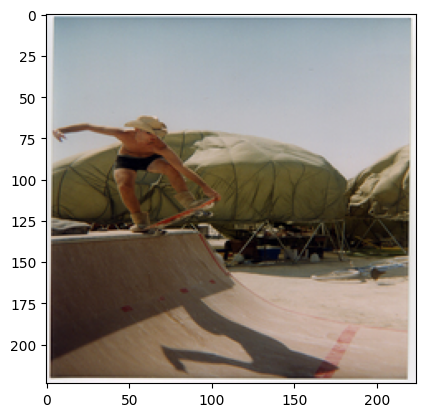

Predicted caption:
 a man is sitting on a bench with a laptop eeee

True captions:
shirtless skateboarder going down a ramp on clear day 
a male shirtless skateboarder is doing a trick
A man riding a skateboard on top of a cement rail.
A man with a cowboy hat on doing a trick on a skateboard.
A skateboarder in cowboy hat just about to go down a ramp


In [ ]:
generate_caption_coco(idx=153, train=False)

# Заключение

Теперь вы представляете, как работает аннотирование изображений. Примеры здесь не очень впечатляющие, да?

Главная причина - ограниченность времени и ресурсов компьютера. Имея более мощные компьютеры, больше времени, более сложные нейронные сети, можно достичь гораздо более правдоподобных результатов.

Смотрите примеры здесь:
* https://milhidaka.github.io/chainer-image-caption/
* http://srijan-ds-intelligent-image-captioning.s3-website.us-east-2.amazonaws.com/
* http://max-image-caption-generator-web-app.codait-prod-41208c73af8fca213512856c7a09db52-0000.us-east.containers.appdomain.cloud/


Конечно, можно использовать и другие нейронные сети для генерации, например, Transformer. Описание и примеры кода смотрите [здесь](https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa)

Возможна и обратная задача: по текстовому описанию сгенерировать картинку, хотя она, конечно, гораздо более сложная: https://openai.com/blog/dall-e/



# Ссылки
Использованы и адаптированы материалы

https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb#scrollTo=rhs_eEzYi_-s

